# **Group Relative Policy Optimization (GRPO)**  

**Group Relative Policy Optimization (GRPO)** enhances traditional Proximal Policy Optimization (PPO) by reducing noise and variance during training, especially when dealing with tasks like text generation. Instead of updating the policy using a single response per query, GRPO samples multiple responses and averages their rewards to capture a more representative signal. This approach helps smooth out noise that can arise from individual, potentially suboptimal responses and ensures that policy updates are guided by a more stable and generalizable signal. By reducing the reliance on any one response, GRPO stabilizes the optimization process and prevents the model from overfitting to specific samples.

The core reason GRPO reduces variance is through reward aggregation across multiple sampled responses. When relying on a single path (as in vanilla PPO), randomness in sampling or noisy feedback can cause unstable updates. By averaging rewards across multiple responses, GRPO approximates the expected reward, mitigating the effect of outliers and noisy samples. This variance reduction allows the policy to learn robustly, generalizing its behavior across a broader range of possible outputs without being overly sensitive to specific responses.

Probability ratio clipping further stabilizes GRPO by preventing excessive policy shifts during updates. The ratio, which compares how much the new policy diverges from the old, is clipped within a defined range to avoid over-updating based on extreme samples. Combined with reward averaging, this mechanism ensures that the model takes gradual, meaningful steps in optimization without erratic behavior. In text generation, this approach prevents the model from overreacting to rare or overly favorable completions, fostering controlled exploration of diverse outputs.

GRPO's effectiveness also comes from incorporating techniques like KL divergence regularization, which keeps the policy anchored to its original language generation capabilities. The grouping mechanism—sampling multiple responses per query—is particularly valuable when rewards are derived from human feedback, which can be inconsistent or noisy. By averaging across diverse responses, GRPO reduces the risk of overfitting to specific preferences, resulting in a more generalizable and scalable policy for tasks involving complex and sequential outputs.

This group-level aggregation is critical when working with long, complex outputs (like text generation) because the reward signal for a single output might be noisy. By considering multiple completions, we smooth out the noise.

## **Step 1: Sampling Queries $q \sim P(Q)$**
We randomly sample queries $q$ from the distribution of possible prompts $P(Q)$. This distribution represents **real-world tasks** or **user inputs** that the model will be trained to handle.

**Examples of prompts:**  
- "The best food in the world is"  
- "Corgis are"  

This step forms the basis of RLHF tasks where the model needs to generate responses aligned with user preferences or reward feedback.

## **Step 2: Sampling $G$ Full Responses Per Query**
For each query $q$, we sample **G possible responses (sequences of tokens)** from the **old policy** $\pi_\theta^{\text{old}}$. Instead of just predicting a single token, the model generates **entire responses of length $T$** by sampling the next token sequentially until the response is complete.

**Example:** If the query is "The capital of France is," the G possible responses could be:  
- $o_1$ = "Paris is a beautiful city with historic landmarks."  
- $o_2$ = "Paris, home to the Eiffel Tower and the Louvre."  
- $o_3$ = "Paris, the cultural and political hub of France."  

This process ensures that the model explores **different potential completions** for each prompt, enabling the policy to generalize across a variety of outputs.

## **Step 3: Why Are We Sampling $G$ Full Responses?**
Sampling **multiple full responses per query** helps reduce variance and ensures that the policy update is stable and generalizable. Instead of relying on a single sampled output (which may be noisy or suboptimal), the model evaluates multiple possible completions, making it robust across different scenarios.

**Key benefits of sampling $G$ responses:**
- **Variance reduction:** By averaging the PPO objective across $G$ outputs, the model avoids overfitting to any particular sampled response.
- **Stable policy updates:** Evaluating multiple responses per query ensures that the updates are consistent across different completions.
- **Improved exploration:** The model can explore different possible responses and select the most reward-aligned behavior.

## **Step 4: Computing the PPO Objective for Full Responses**
The main PPO objective evaluates the **probability ratios** between the new policy $\pi_\theta$ and the old policy $\pi_\theta^{\text{old}}$, weighted by the **advantage** of each response.

The **probability of a full response** $o_i = [o_1, o_2, ..., o_T]$ under a policy is calculated as:

$$
\pi_\theta(o \mid q) = \prod_{t=1}^{T} \pi_\theta(o_t \mid o_{<t}, q)
$$

In practice, we compute the **log-probability of the entire sequence** to avoid numerical underflow:

$$
\log \pi_\theta(o \mid q) = \sum_{t=1}^{T} \log \pi_\theta(o_t \mid o_{<t}, q)
$$

The PPO objective compares the **log-probabilities of the new policy and old policy**:

$$
\text{Ratio} = \exp\left( \log \pi_\theta(o \mid q) - \log \pi_\theta^{\text{old}}(o \mid q) \right)
$$

The **advantage function** $A_i$ quantifies how much better a sampled response $o_i$ is compared to the expected baseline:

$$
A_i = \frac{r_i - \text{mean}(r_1, ..., r_G)}{\text{std}(r_1, ..., r_G)}
$$

We then apply **clipping** to the probability ratio to ensure that updates do not deviate too much from the old policy:

$$
\text{Clipped objective} = \min \left( \text{Ratio} \times A_i, \text{clip}(\text{Ratio}, 1 - \epsilon, 1 + \epsilon) \times A_i \right)
$$

## **Step 5: Averaging the PPO Loss Across Queries and Responses**
We compute the expectation $\mathbb{E}$ by averaging the PPO objective over both the sampled queries and the $G$ sampled responses for each query:

$$
J_{\text{GRPO}}(\theta) = \mathbb{E}_{q \sim P(Q), \{o_i\}_{i=1}^G \sim \pi_\theta^{\text{old}}} \left[ \frac{1}{G} \sum_{i=1}^G \text{Clipped objective} \right]
$$

This ensures that the policy update is guided by the **average performance across multiple responses** rather than being sensitive to individual samples.

## **Step 6: KL Regularization to Control Response Length and Safety**
The KL divergence penalty $D_{KL}(\pi_\theta \parallel \pi_{\text{ref}})$ prevents the new policy from deviating too far from a **reference policy** $\pi_{\text{ref}}$, which could be the original pre-trained model or a simpler model like DistilGPT-2.

$$
D_{KL}(\pi_\theta \parallel \pi_{\text{ref}}) = \sum_{o_i} \pi_{\text{ref}}(o_i \mid q) \log \frac{\pi_{\text{ref}}(o_i \mid q)}{\pi_\theta(o_i \mid q)}
$$

### **Why is KL regularization important?**
- **Maintains fluency and coherence:** Penalizing large deviations ensures that the model retains its general language generation ability while optimizing for rewards.
- **Controls response length:** A larger KL weight $\beta$ penalizes long or risky completions, encouraging the model to generate shorter, safer responses.
- **Balances exploration and exploitation:** By tuning $\beta$, we can allow the model to explore creative outputs while staying anchored to its pre-trained knowledge.

## **Step 7: When to Use a Reference Policy**
The reference policy is essential in cases where:
- **We are fine-tuning a pre-trained model:** To ensure that the model doesn’t lose its general knowledge.
- **In RLHF settings:** To balance maximizing rewards with preserving fluency and coherence.
- **To control output length and verbosity:** Increasing $\beta$ encourages shorter, safer responses, while decreasing it allows for more diverse and creative outputs.

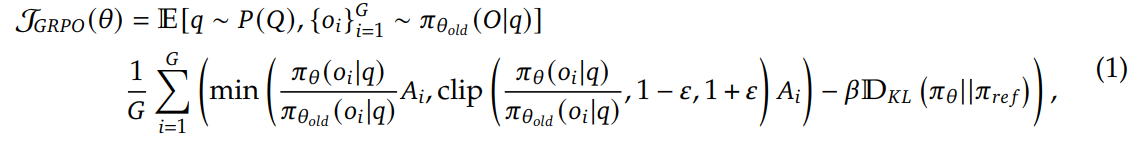


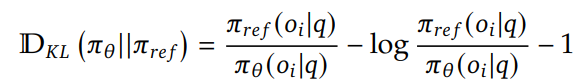


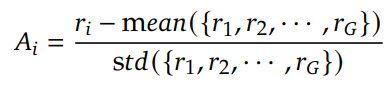


## **Final Summary:**  
1. **Sample queries** from the distribution P(Q) 
2. **Generate G full responses** per query using the old policy.  
3. **Compute the PPO objective** by comparing the new policy to the old policy, weighted by advantages.  
4. **Apply KL regularization** using the reference policy to balance exploration and safety.  
5. **Update the model parameters** by averaging the PPO loss across queries and responses.

This process ensures that the model improves consistently, remains stable during training, and balances reward maximization with coherence and safety. 😊

# References:
[DeepSeek-R1: Incentivizing Reasoning Capability in LLMs via Reinforcement Learning](https://arxiv.org/abs/2501.12948)

[DeepSeekMath: Pushing the Limits of Mathematical Reasoning in Open Language Models](https://arxiv.org/pdf/2402.03300)


In [1]:
import torch
import torch.nn.functional as F
from transformers import AutoModelForCausalLM, AutoTokenizer, TopKLogitsWarper
import numpy as np

In [2]:
# Initialize tokenizer and add PAD token
tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

# Initialize Models
new_model = AutoModelForCausalLM.from_pretrained(
    "gpt2"
)  # New policy model (to be optimized)
old_model = AutoModelForCausalLM.from_pretrained(
    "gpt2"
)  # Old policy model (before update)
reference_model = AutoModelForCausalLM.from_pretrained(
    "distilgpt2"
)  # Optional reference policy

In [3]:
# Sample batch of prompts (queries)
prompts = [
    "The best food in the world is",
    "Corgis are",
    "The meaning of life is",
    "I am",
    "The most important thing in the world is",
]

# Tokenize prompts and get logits
inputs = tokenizer(prompts, return_tensors="pt", padding=True, truncation=True)

In [4]:
def sample_sequences(
    model, tokenizer, inputs, max_length=50, top_k=50, n_sample_sequences=1
):
    """
    Sample n_sample_sequences sequences per prompt using top-k sampling.

    Args:
        model: The model used for sequence generation.
        tokenizer: The tokenizer corresponding to the model.
        inputs: Tokenized input prompts.
        max_length: Maximum length of generated sequences.
        top_k: The top-k filtering value for sampling.
        n_sample_sequences: Number of sequences to sample per prompt.

    Returns:
        Tensor of shape (batch_size, n_sample_sequences, sequence_length) containing generated tokens.
    """
    G = n_sample_sequences
    input_ids = inputs["input_ids"]
    attention_mask = inputs["attention_mask"]
    batch_size = input_ids.size(0)

    # Initialize the top-k warper
    top_k_warper = TopKLogitsWarper(top_k=top_k)

    # Expand input tensors for G samples per prompt
    # Expand changes the shape from (batch_size, sequence_length) to (batch_size, G, sequence_length)
    # Shape: (batch_size, sequence_length) -> (batch_size, G, sequence_length) -> (batch_size * G, sequence_length)
    input_ids = (
        input_ids.unsqueeze(1).expand(batch_size, G, -1).reshape(batch_size * G, -1)
    )

    # Expand attention mask to match input_ids with G samples
    # Shape: (batch_size, sequence_length) -> (batch_size, G, sequence_length) -> (batch_size * G, sequence_length)
    attention_mask = (
        attention_mask.unsqueeze(1)
        .expand(batch_size, G, -1)
        .reshape(batch_size * G, -1)
    )

    # Start with the initial prompts
    generated_sequences = input_ids.clone()

    for _ in range(max_length):
        with torch.no_grad():
            # Forward pass through the model
            outputs = model(
                input_ids=generated_sequences,
                attention_mask=attention_mask,
            )
            logits = outputs.logits[:, -1, :]  # Logits for the last token

            # Apply top-k filtering
            filtered_logits = top_k_warper(None, logits)
            probs = F.softmax(filtered_logits, dim=-1)

            # Sample next tokens
            next_tokens = torch.multinomial(probs, num_samples=1)  # (batch_size * G, 1)

            # Check for EOS token and break if all sequences end
            if (next_tokens == tokenizer.eos_token_id).all():
                break

            # Append the sampled token to the sequence
            generated_sequences = torch.cat([generated_sequences, next_tokens], dim=1)

            # Update attention mask
            attention_mask = torch.cat(
                [
                    attention_mask,
                    torch.ones(
                        (attention_mask.size(0), 1), device=attention_mask.device
                    ),
                ],
                dim=1,
            )

    # Reshape to (batch_size, G, sequence_length)
    generated_sequences = generated_sequences.view(batch_size, G, -1)
    return generated_sequences

In [5]:
# Sample G sequences per query using each policy
new_policy_sequences = sample_sequences(
    new_model,
    tokenizer,
    inputs,
    max_length=10,
    top_k=50,
    n_sample_sequences=5,
)
old_policy_sequences = sample_sequences(
    old_model,
    tokenizer,
    inputs,
    max_length=10,
    top_k=50,
    n_sample_sequences=5,
)
reference_policy_sequences = sample_sequences(
    reference_model,
    tokenizer,
    inputs,
    max_length=10,
    top_k=50,
    n_sample_sequences=5,
)

In [7]:
def compute_sequence_log_probs(model, sequences, inputs):
    """
    Compute the log-probability of each sampled sequence under the model.

    Args:
        model: The model used for log-probability computation.
        sequences: Tensor of shape (batch_size, G, seq_len) containing the sampled sequences.
        inputs: The tokenized input prompts used for generation.

    Returns:
        Tensor of shape (batch_size, G) containing the log-probability of each sequence.
    """
    batch_size, G, seq_len = sequences.size()
    log_probs = torch.zeros(
        (batch_size, G), device=sequences.device
    )  # Initialize on the correct device

    # Concatenate inputs and sequences for all G sequences in one batch to avoid looping
    full_inputs = torch.cat(
        [
            inputs["input_ids"]
            .unsqueeze(1)
            .expand(batch_size, G, -1),  # Expand original inputs to match G sequences
            sequences,
        ],
        dim=2,
    ).reshape(
        batch_size * G, -1
    )  # Reshape to (batch_size * G, full_sequence_length)

    attention_mask = torch.cat(
        [
            inputs["attention_mask"].unsqueeze(1).expand(batch_size, G, -1),
            torch.ones(
                (batch_size, G, seq_len), device=sequences.device
            ),  # Extend attention for the new tokens
        ],
        dim=2,
    ).reshape(batch_size * G, -1)

    with torch.no_grad():
        # Compute logits for all input sequences in one forward pass
        logits = model(input_ids=full_inputs, attention_mask=attention_mask).logits

    # Compute token log-probabilities
    token_log_probs = F.log_softmax(logits, dim=-1)

    # Gather the log-probabilities of the actual sampled tokens
    sampled_token_probs = torch.gather(
        token_log_probs[
            :, inputs["input_ids"].size(1) :, :
        ],  # Log-probs of the new generated tokens only
        2,
        sequences.reshape(batch_size * G, seq_len).unsqueeze(-1),
    ).squeeze(
        -1
    )  # Shape: (batch_size * G, seq_len)

    # Sum log-probabilities along the sequence length
    log_probs = sampled_token_probs.sum(dim=1).reshape(
        batch_size, G
    )  # Reshape back to (batch_size, G)

    return log_probs

In [ ]:
new_policy_log_probs = compute_sequence_log_probs(
    new_model, new_policy_sequences, inputs
)
old_policy_log_probs = compute_sequence_log_probs(
    old_model, old_policy_sequences, inputs
)
reference_log_probs = compute_sequence_log_probs(
    reference_model, reference_policy_sequences, inputs
)


print("New policy log-probs:", new_policy_log_probs)
print("Old policy log-probs:", old_policy_log_probs)
print("Reference policy log-probs:", reference_log_probs)

In [9]:
# Mock rewards for demonstration (one reward per sampled token)
rewards = torch.tensor(
    [
        [1.5, 1.8, 2.0, 1.2, 1.6],  # Rewards for G samples for query 1
        [2.0, 1.9, 1.5, 1.4, 1.7],  # Rewards for G samples for query 2
        [1.0, 1.2, 1.3, 1.1, 1.5],  # Rewards for G samples for query 3
        [1.8, 1.7, 1.9, 1.6, 1.5],  # Rewards for G samples for query 4
        [1.2, 1.4, 1.3, 1.5, 1.1],  # Rewards for G samples for query 5
    ]
)

In [10]:
# Compute normalized advantages
def compute_advantages(rewards: torch.Tensor) -> torch.Tensor:
    mean_reward = rewards.mean(dim=1, keepdim=True)
    std_reward = rewards.std(dim=1, unbiased=False, keepdim=True)
    advantages = (rewards - mean_reward) / (std_reward + 1e-8)
    return advantages

In [ ]:
advantages = compute_advantages(rewards)
print("Advantages:", advantages)

In [12]:
def ppo_loss(
    new_probs: torch.Tensor,
    old_probs: torch.Tensor,
    advantages: torch.Tensor,
    epsilon: float = 0.2,
    beta: float = 0.01,
    reference_probs: torch.Tensor = None,
) -> torch.Tensor:
    # Compute clipped objective
    ratios = torch.exp(new_probs - old_probs)  # exp(log(new) - log(old))
    clipped_ratios = torch.clamp(ratios, 1 - epsilon, 1 + epsilon)
    clipped_objective = torch.min(ratios * advantages, clipped_ratios * advantages)

    # Compute KL divergence penalty
    if reference_probs is not None:
        kl_div = F.kl_div(new_probs, reference_probs, reduction="batchmean")

    # Final PPO loss (negative to maximize)
    loss = -torch.mean(clipped_objective) + beta * kl_div
    return loss

In [ ]:
# Compute PPO loss across G sampled outputs
ppo_loss_value = ppo_loss(
    new_probs=new_policy_log_probs,
    old_probs=old_policy_log_probs.detach(),  # Old policy is detached to prevent gradient flow
    advantages=advantages,
    epsilon=0.2,
    beta=0.01,
    reference_probs=reference_log_probs,
)

print("PPO Loss:", ppo_loss_value.item())